# 波士顿房价预测任务



In [1]:
import random
import paddle
import numpy as np
from paddle.nn import Linear
import matplotlib.pyplot as plt
import paddle.nn.functional as F

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized


## 数据处理

数据处理包含五个部分：数据导入、数据形状变换、数据集划分、数据归一化处理。数据预处理后，才能被模型调用。


In [2]:
def load_data():
    # 从文件导入数据
    datafile = './work/housing.data'
    data = np.fromfile(datafile, sep=' ', dtype=np.float32)

    # 每条数据包括14项，其中前面13项是影响因素，第14项是相应的房屋价格中位数
    feature_names = [ 'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', \
                      'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV' ]
    feature_num = len(feature_names)

    # 将原始数据进行Reshape，变成[N, 14]这样的形状
    data = data.reshape([data.shape[0] // feature_num, feature_num])

    # 将原数据集拆分成训练集和测试集
    # 这里使用80%的数据做训练，20%的数据做测试
    # 测试集和训练集必须是没有交集的
    ratio = 0.8
    offset = int(data.shape[0] * ratio)
    training_data = data[:offset]

    # 计算train数据集的最大值，最小值，平均值
    maximums, minimums, avgs = training_data.max(axis=0), training_data.min(axis=0), \
                                 training_data.sum(axis=0) / training_data.shape[0]
    
    # 记录数据的归一化参数，在预测时对数据做归一化
    global max_values
    global min_values
    global avg_values
    max_values = maximums
    min_values = minimums
    avg_values = avgs

    # 对数据进行归一化处理
    for i in range(feature_num):
        data[:, i] = (data[:, i] - avgs[i]) / (maximums[i] - minimums[i])

    # 训练集和测试集的划分比例
    training_data = data[:offset]
    test_data = data[offset:]
    return training_data, test_data

## 模型设计与训练

模型设计是深度学习模型关键要素之一，也称为网络结构设计，相当于模型的假设空间，即实现模型“前向计算”（从输入到输出）的过程。

此处模型由输入层、隐藏层、输出层构成，其中隐藏层的节点数为10，输出层的节点数为1；隐藏层输出结果经sigmoid函数激活后，作为第下一层的输入；网络整体由两个全连接层构成。

模型训练采用随机梯度下降法更新网络参数，设定学习率为0.1，batch_size=100

## 1. Numpy版本

In [3]:
def sigmoid(x):
    # sigmoid激活函数
    return 1/(1+np.exp(-x))

def dsigmoid(x):
    # sigmoid激活函数的导数
    return x*(1-x)

In [4]:
class Network(object):
    def __init__(self, num_of_weights,hidden_sum):
        # 随机产生w的初始值
        # 为了保持程序每次运行结果的一致性，此处设置固定的随机数种子
        np.random.seed(0)
        self.w_1 = np.random.randn(num_of_weights, hidden_sum)  # 第一个全连接层的网络参数
        self.b_1 = np.zeros(hidden_sum)
        self.w_2 = np.random.randn(hidden_sum,1)                # 第二个全连接层的网络参数
        self.b_2 = 0.
        
    def forward(self, x):
        # 前向传播
        z = np.dot(x, self.w_1) + self.b_1     # 全连接层
        z = sigmoid(z)                         # sigmoid激活层
        z = np.dot(z, self.w_2) + self.b_2     # 全连接层
        return z
    
    def loss(self, z, y):
        # 均方差损失函数计算
        error = z - y
        cost = error * error
        cost = np.mean(cost) / 2
        return cost
    
    def gradient(self, x, y):
        # 梯度计算
        o_1 = sigmoid(np.dot(x, self.w_1) + self.b_1)    # 第一个全连接层的输出
        z = self.forward(x)                              # 第二个全连接层的输出

        gradient_w_1 = x.T.dot((z-y).dot(self.w_2.T) * dsigmoid(o_1))           # 第一个全连接层参数的梯度
        gradient_b_1 = np.mean((z-y).dot(self.w_2.T) * dsigmoid(o_1), axis=0) 

        # gradient_w_2 = o_1.T.dot((z-y))
        gradient_w_2 = np.mean((z-y)*o_1,axis=0)                                # 第二个全连接层参数的梯度
        gradient_w_2 = gradient_w_2[:,np.newaxis]
        gradient_b_2 = np.mean((z-y))
        return gradient_w_1, gradient_b_1, gradient_w_2, gradient_b_2
    
    def update(self, gradient_w_1, gradient_w_2, gradient_b_1, gradient_b_2, eta = 0.01):
        # 梯度下降，网络参数更新
        self.w_1 = self.w_1 - eta * gradient_w_1
        self.b_1 = self.b_1 - eta * gradient_b_1
        self.w_2 = self.w_2 - eta * gradient_w_2
        self.b_2 = self.b_2 - eta * gradient_b_2
            
                
    def train(self, training_data, num_epochs, batch_size=10, eta=0.01):
        n = len(training_data)
        losses = []
        for epoch_id in range(num_epochs):
            # 在每轮迭代开始之前，将训练数据的顺序随机打乱
            # 然后再按每次取batch_size条数据的方式取出
            np.random.shuffle(training_data)
            # 将训练数据进行拆分，每个mini_batch包含batch_size条的数据
            mini_batches = [training_data[k:k+batch_size] for k in range(0, n, batch_size)]
            for iter_id, mini_batch in enumerate(mini_batches):
                #print(self.w.shape)
                #print(self.b)
                x = mini_batch[:, :-1]   # 特征
                y = mini_batch[:, -1:]   # 标签
                a = self.forward(x)      # 网络输出
                loss = self.loss(a, y)   # 网络损失
                gradient_w_1, gradient_b_1, gradient_w_2, gradient_b_2 = self.gradient(x, y)  # 参数梯度
                self.update(gradient_w_1, gradient_w_2, gradient_b_1, gradient_b_2, eta)      # 更新参数
                losses.append(loss)                                                           # 记录损失
                print('Epoch {:3d} / iter {:3d}, loss = {:.4f}'.
                                 format(epoch_id, iter_id, loss))
        
        return losses

    def test(self,test_data):
        x = test_data[:, :-1]   # 特征
        y = test_data[:, -1:]   # 标签
        a = self.forward(x)      # 网络输出
        loss = self.loss(a, y)   # 网络损失
        print('The testing loss = {:.4f}'.format(loss))

    def eval(self,test_data):
        idx = -10
        global label_
        # idx = np.random.randint(0, test_data.shape[0])
        one_data, label_ = test_data[idx, :-1], test_data[idx, -1]
        one_data =  one_data.reshape([1,-1])      # 修改该条数据shape为[1,13]
        
        
        
        predict = self.forward(one_data)
        predict = np.squeeze(predict)   # 去除冗余维度
        loss = self.loss(predict, label_)

        # 对结果做反归一化处理
        predict = predict * (max_values[-1] - min_values[-1]) + avg_values[-1]
        # 对label数据做反归一化处理
        label_ = label_ * (max_values[-1] - min_values[-1]) + avg_values[-1]

        print("Inference result is {}, the corresponding label is {}, the loss is {}".format(predict, label_, loss))


## 2. Paddle版本

In [5]:
class Regressor(paddle.nn.Layer):

    def __init__(self):
        # 初始化父类中的一些参数
        super(Regressor, self).__init__()
        
        # 定义两层全连接层
        self.fc1 = Linear(in_features=13, out_features=10)  # 输入维度是13，输出维度是10
        self.fc2 = Linear(in_features=10, out_features=1)   # 输入维度是10，输出维度是1
    
    # 网络的前向计算
    def forward(self, inputs):
        x = F.sigmoid(self.fc1(inputs))
        x = self.fc2(x)
        return x

def train(EPOCH_NUM,BATCH_SIZE):
    # 定义外层循环
    losses = []
    for epoch_id in range(EPOCH_NUM):
        # 在每轮迭代开始之前，将训练数据的顺序随机的打乱
        np.random.shuffle(training_data)
        # 将训练数据进行拆分，每个batch包含10条数据
        mini_batches = [training_data[k:k+BATCH_SIZE] for k in range(0, len(training_data), BATCH_SIZE)]
        # 定义内层循环
        for iter_id, mini_batch in enumerate(mini_batches):
            x = np.array(mini_batch[:, :-1]) # 获得当前批次训练数据
            y = np.array(mini_batch[:, -1:]) # 获得当前批次训练标签（真实房价）
            # 将numpy数据转为飞桨动态图tensor形式
            house_features = paddle.to_tensor(x)
            prices = paddle.to_tensor(y)
            
            # 前向计算
            predicts = model(house_features)
            
            # 计算损失
            loss = F.square_error_cost(predicts, label=prices)
            avg_loss = paddle.mean(loss)
            losses.append(np.squeeze(avg_loss.numpy()))
            if iter_id%20==0:
                print("epoch: {}, iter: {}, loss is: {}".format(epoch_id, iter_id, np.squeeze(avg_loss.numpy())))
            
            # 反向传播
            avg_loss.backward()
            # 最小化loss,更新参数
            opt.step()
            # 清除梯度
            opt.clear_grad()
    return losses
    
def testing():
    x = np.array(test_data[:, :-1]) # 获得当前批次训练数据
    y = np.array(test_data[:, -1:]) # 获得当前批次训练标签（真实房价）
    # 将numpy数据转为飞桨动态图tensor形式
    house_features = paddle.to_tensor(x)
    prices = paddle.to_tensor(y)
    
    # 前向计算
    predicts = model(house_features)
    
    # 计算损失
    loss = F.square_error_cost(predicts, label=prices)
    avg_loss = paddle.mean(loss)
    print("The test loss is: {}".format(np.squeeze(avg_loss.numpy())))


def load_one_example():
    # 从上边已加载的测试集中，随机选择一条作为测试数据
    # idx = np.random.randint(0, test_data.shape[0])
    idx = -10
    one_data, label = test_data[idx, :-1], test_data[idx, -1]
    # 修改该条数据shape为[1,13]
    one_data =  one_data.reshape([1,-1])

    return one_data, label


def eval():

    # 参数为保存模型参数的文件地址
    model_dict = paddle.load('LR_model.pdparams')
    model.load_dict(model_dict)
    model.eval()

    # 参数为数据集的文件地址
    one_data, label = load_one_example()
    # 将数据转为动态图的variable格式 
    one_data = paddle.to_tensor(one_data)
    label = paddle.to_tensor(label)
    
    predict = model(one_data)
    loss = F.square_error_cost(predict, label=label)
    avg_loss = paddle.mean(loss)

    # 对结果做反归一化处理
    predict = predict * (max_values[-1] - min_values[-1]) + avg_values[-1]
    predict = np.squeeze(predict)
    # 对label数据做反归一化处理
    label = label * (max_values[-1] - min_values[-1]) + avg_values[-1]
    label = np.squeeze(label.numpy())

    print("Inference result is {}, the corresponding label is {}, the loss is {}".format(predict.numpy(), label_,np.squeeze(avg_loss.numpy()))) 


### 训练过程

设定训练epoch = 50

Epoch   0 / iter   0, loss = 0.1901
Epoch   0 / iter   1, loss = 0.0766
Epoch   0 / iter   2, loss = 0.0515
Epoch   0 / iter   3, loss = 0.0204
Epoch   0 / iter   4, loss = 0.0451
Epoch   1 / iter   0, loss = 0.0174
Epoch   1 / iter   1, loss = 0.0138
Epoch   1 / iter   2, loss = 0.0094
Epoch   1 / iter   3, loss = 0.0094
Epoch   1 / iter   4, loss = 0.0034
Epoch   2 / iter   0, loss = 0.0091
Epoch   2 / iter   1, loss = 0.0119
Epoch   2 / iter   2, loss = 0.0084
Epoch   2 / iter   3, loss = 0.0090
Epoch   2 / iter   4, loss = 0.0075
Epoch   3 / iter   0, loss = 0.0137
Epoch   3 / iter   1, loss = 0.0074
Epoch   3 / iter   2, loss = 0.0068
Epoch   3 / iter   3, loss = 0.0057
Epoch   3 / iter   4, loss = 0.0160
Epoch   4 / iter   0, loss = 0.0068
Epoch   4 / iter   1, loss = 0.0076
Epoch   4 / iter   2, loss = 0.0056
Epoch   4 / iter   3, loss = 0.0118
Epoch   4 / iter   4, loss = 0.0042
Epoch   5 / iter   0, loss = 0.0101
Epoch   5 / iter   1, loss = 0.0046
Epoch   5 / iter   2, loss =

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


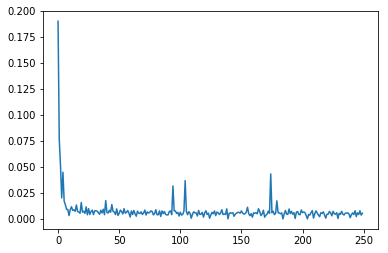

epoch: 0, iter: 0, loss is: 0.49117088317871094
epoch: 1, iter: 0, loss is: 0.03759972006082535
epoch: 2, iter: 0, loss is: 0.044807370752096176
epoch: 3, iter: 0, loss is: 0.04970204457640648
epoch: 4, iter: 0, loss is: 0.037459488958120346
epoch: 5, iter: 0, loss is: 0.029677798971533775
epoch: 6, iter: 0, loss is: 0.03960109129548073
epoch: 7, iter: 0, loss is: 0.03276403248310089
epoch: 8, iter: 0, loss is: 0.02916741371154785
epoch: 9, iter: 0, loss is: 0.03215372562408447
epoch: 10, iter: 0, loss is: 0.033913273364305496
epoch: 11, iter: 0, loss is: 0.036246150732040405
epoch: 12, iter: 0, loss is: 0.0246120635420084
epoch: 13, iter: 0, loss is: 0.03926193341612816
epoch: 14, iter: 0, loss is: 0.039168890565633774
epoch: 15, iter: 0, loss is: 0.04686536639928818
epoch: 16, iter: 0, loss is: 0.03759617730975151
epoch: 17, iter: 0, loss is: 0.02586863562464714
epoch: 18, iter: 0, loss is: 0.027783626690506935
epoch: 19, iter: 0, loss is: 0.034179460257291794
epoch: 20, iter: 0, los

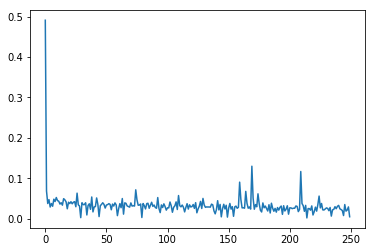

模型保存成功，模型参数保存在LR_model.pdparams中


In [6]:
if __name__ == '__main__':
    #########################Numpy版本###############################
    # 获取数据
    training_data, test_data = load_data()

    # 创建网络
    net = Network(13,10)   # 隐层节点数10

    # 启动训练
    # mini_batch,batch_size=100,learning_rate=0.1
    losses = net.train(training_data, num_epochs=50, batch_size=100, eta=0.1)  

    # 画出损失函数的变化趋势
    plot_x = np.arange(len(losses))
    plot_y = np.array(losses)
    plt.plot(plot_x, plot_y)
    plt.show()

    ########################Paddle版本###################################
    # 声明定义好的线性回归模型
    model = Regressor()
    # 开启模型训练模式
    model.train()
    # 加载数据
    
    # 定义优化算法，使用随机梯度下降SGD
    # 学习率设置为0.1
    opt = paddle.optimizer.SGD(learning_rate=0.1, parameters=model.parameters())


    EPOCH_NUM = 50   # 设置外层循环次数
    BATCH_SIZE = 100  # 设置batch大小

    losses = train(EPOCH_NUM, BATCH_SIZE)
    
    plot_x = np.arange(len(losses))
    plot_y = np.array(losses)
    plt.plot(plot_x, plot_y)
    plt.show()

    # 保存模型参数，文件名为LR_model.pdparams
    paddle.save(model.state_dict(), 'LR_model.pdparams')
    print("模型保存成功，模型参数保存在LR_model.pdparams中")


In [7]:
########################Numpy版本####################################
net.test(test_data)   # 测试集上的损失
net.eval(test_data)   # 某一条数据的验证

########################Paddle版本###################################
testing()             # 测试集上的损失
eval()                # 某一条数据的验证

The testing loss = 0.0048
Inference result is 11.82583342343917, the corresponding label is 19.700000762939453, the loss is 0.01530926262645376
The test loss is: 0.01366349309682846
Inference result is 17.76057243347168, the corresponding label is 19.700000762939453, the loss is 0.0015361009864136577
